<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

### Contents


- **[1]()**: Download and Import the Quora Insincere Questions Dataset
- **[2]()**: Create tf.data.Datasets for Training and Evaluation
- **[3]()**: Download a Pre-trained BERT Model from TensorFlow Hub
- **[4]()**: Tokenize and Preprocess Text for BERT
- **[5]()**: Wrap a Python Function into a TensorFlow op for Eager Execution
- **[6]()**: Create a TensorFlow Input Pipeline with `tf.data`
- **[7]()**: Add a Classification Head to the BERT `hub.KerasLayer`
- **[8]()**: Fine-Tune BERT for Text Classification
- **[9]()**: Evaluate the BERT Text Classification Model

In [1]:
!nvidia-smi

Thu Nov 26 11:54:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [2]:
import tensorflow as tf

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [4]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt

## 1: Download and Import the Quora Insincere Questions Dataset

In [5]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [6]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [7]:
df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip', 
                 compression='zip', low_memory=False)
df

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [8]:
df.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

## 2: Create tf.data.Datasets for Training and Evaluation

In [61]:
train ,validation = train_test_split(df, train_size=0.60, random_state=42, stratify=df.target.values)
validation, test = train_test_split(validation, random_state=42, test_size=0.5, stratify=validation.target.values)
print("Train Shape\tValid Shape\tTest Shape")
train.shape, validation.shape, test.shape

Train Shape	Valid Shape	Test Shape


((783673, 3), (261224, 3), (261225, 3))

In [62]:
 with tf.device('/cpu:0'):
   train_data = tf.data.Dataset.from_tensor_slices((train['question_text'].values, train['target'].values))
   valid_data = tf.data.Dataset.from_tensor_slices((validation['question_text'].values, validation['target'].values))
   test_data = tf.data.Dataset.from_tensor_slices((test['question_text'].values, test['target'].values))

   for text, label in train_data.take(1):
     print(test)
     print(label)

                          qid  ... target
22004    0452e4e5b5c34944bc36  ...      0
1013706  c6a65b5d62175723a176  ...      0
659002   8114ca3a08a56ade83d9  ...      0
1299258  fea6446c17da271b7426  ...      0
850519   a6a69b2770aa2dcf3073  ...      0
...                       ...  ...    ...
503308   628c8ecf3b45b64c0a65  ...      0
1065936  d0e1a71eee5f806706f2  ...      0
319173   3e8d066aed1996792729  ...      0
286674   3823c5055028979fa0ab  ...      0
131093   19a5635a21c045709a26  ...      0

[261225 rows x 3 columns]
tf.Tensor(0, shape=(), dtype=int64)


## 3: Download a Pre-trained BERT Model from TensorFlow Hub

In [11]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""
labels_list = [0, 1]
max_seq_len = 150
batch = 64

#: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=False)
vocab = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab, do_lower_case)

In [12]:
tokenizer.wordpiece_tokenizer.tokenize("hi, how, are you")

['hi', '##,', 'how', '##,', 'are', 'you']

In [13]:
tokenizer.wordpiece_tokenizer.tokenize("hi, How, are you")

['hi', '##,', '[UNK]', 'are', 'you']

In [14]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi, how, are you"))

[7632, 29623, 2129, 29623, 2024, 2017]

## 4: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray"> BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [55]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=labels_list, max_seq_length=max_seq_len, tokenizer=tokenizer):
   
   example = classifier_data_lib.InputExample(guid=None,
                                              text_a=text.numpy(),
                                              text_b=None,
                                              label=label.numpy()
                                              )
   feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
   
   return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

We want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode we can only use TensorFlow Ops and functions.

So we can't `.map` this function directly: We need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## 5: Wrap a Python Function into a TensorFlow op for Eager Execution

In [56]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32]
                                                                )
  input_ids.set_shape([max_seq_len])
  input_mask.set_shape([max_seq_len])
  segment_ids.set_shape([max_seq_len])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
       'input_mask':input_mask,
       'input_type_ids':segment_ids
  }
  return (x, label_id) 

## 6: Create a TensorFlow Input Pipeline with `tf.data`

In [63]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE
                               )
  .shuffle(1000)
  .batch(batch, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE)
  )

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE
                               )
  .batch(batch, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE)
  )
  
  # test
  test_data = (test_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE
                               )
  .batch(batch, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE)
  )
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [64]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None)},
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

In [65]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(64, 150), dtype=tf.int32, name=None)},
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

## 7: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray"> BERT Layer</p>
</div>

In [33]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                   name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                    name="segment_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

  drop = tf.keras.layers.Dropout(0.3)(pooled_output)
  dense_1 = tf.keras.layers.Dense(512, activation='relu')(drop)
  dense_2 = tf.keras.layers.Dense(1024, activation='relu')(dense_1)
  dense_3 = tf.keras.layers.Dense(1024, activation='relu')(dense_2)
  drop = tf.keras.layers.Dropout(0.4)(dense_3)
  
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)

  model = tf.keras.Model(
      {
        'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
      },
      output
  )
  return model

## 8: Fine-Tune BERT for Text Classification

In [34]:
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['binary_accuracy']
)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 150)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 150)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

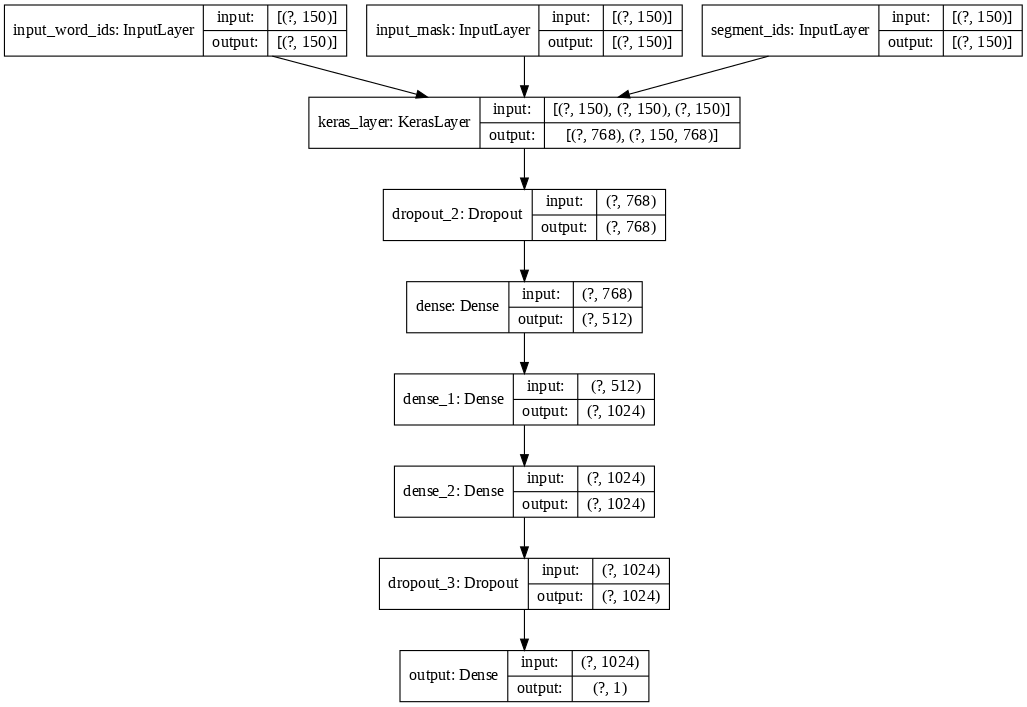

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=80)

In [66]:
# Train model
h = model.fit(train_data, validation_data=valid_data,
              epochs=2
)

Epoch 1/2
    2/12244 [..............................] - ETA: 1:13:54 - loss: 0.1812 - binary_accuracy: 0.9531WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0267s vs `on_train_batch_end` time: 0.3429s). Check your callbacks.


12244/12244 [==============================] - ETA: 0s - loss: 0.1759 - binary_accuracy: 0.9396WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_test_batch_end` time: 0.3425s). Check your callbacks.


12244/12244 [==============================] - 5965s 487ms/step - loss: 0.1759 - binary_accuracy: 0.9396 - val_loss: 0.1529 - val_binary_accuracy: 0.9419
Epoch 2/2
12244/12244 [==============================] - 5962s 487ms/step - loss: 0.1681 - binary_accuracy: 0.9404 - val_loss: 0.1484 - val_binary_accuracy: 0.9427


## 9: Evaluate the BERT Text Classification Model

In [67]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

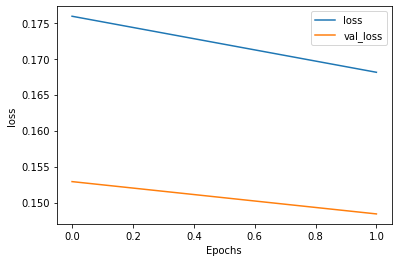

In [69]:
plot_graphs(h, 'loss')

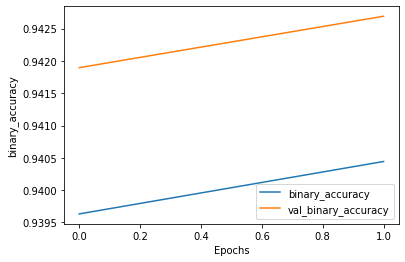

In [70]:
plot_graphs(h, 'binary_accuracy')

In [71]:
model.evaluate(test_data)

   2/4081 [..............................] - ETA: 24:21 - loss: 0.1205 - binary_accuracy: 0.9609WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0219s vs `on_test_batch_end` time: 0.3438s). Check your callbacks.


4081/4081 [==============================] - 1493s 366ms/step - loss: 0.1481 - binary_accuracy: 0.9427


[0.14811307191848755, 0.9426917433738708]

In [78]:
sample_example = ['may i have your number??']
ques = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
ques = (ques.map(to_feature_map)).batch(1)
pred = model.predict(ques)[0][0]
t = 0.5
['Insincere' if pred>=t else 'Sincere']

['Sincere']